# Mise en place d'un modéle détectant les faux billets

L’Organisation Nationale de lutte Contre le Faux-Monnayage (ONCFM), institution ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros, nous a solliciter afin de mettre en place un moyen de différencier les faux des vrais billets, et ce à partir simplement de certaines dimensions des billets et des éléments qui les composent.

**Objectif de cette étude** : Mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets.

Nous allons commencer par effectuer une analyse exploratoire des données mises à notre disposition.

### Chargement des librairies nécessaires à l'analyse

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import f_oneway, shapiro
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
from functions import *
warnings.filterwarnings("ignore")
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Chargement des données relatives aux billets

In [2]:
# Import et visualisation du fichier transmis

billets = pd.read_csv('Billets.csv', sep=";", decimal='.')
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [3]:
billets.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


In [4]:
billets.shape

(1500, 7)

In [5]:
# Affichage des valeurs que la variable 'is_genuine' peut prendre

billets['is_genuine'].unique()

array([ True, False])

In [6]:
# Vérification de la répartition des données

billets['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

Nous allons ajouter à notre dataframe une variable numérique traitant l'authenticité des billets (0 pour '*False*' et 1 pour '*True*').

In [7]:
# Création d'une variable numérique similaire à 'is_genuine'

table = pd.DataFrame({'is_genuine': [True, False], 'authenticity': [1, 0]})
table.head()

,is_genuine,authenticity
0,True,1
1,False,0


In [8]:
# Jointure entre notre les tables 'billets' et 'table'

billets = pd.merge(billets, table, on='is_genuine')
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1


In [9]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
 7   authenticity  1500 non-null   int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 95.2 KB


Il semblerait que nous ayons des valeurs manquantes au sein de nos données. Identifions-les et traitons-les.

### Identification des données manquantes

In [10]:
# Recherche des valeurs manquantes

billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
authenticity     0
dtype: int64

In [11]:
billets[billets['margin_low'].isnull()]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity
72,True,171.94,103.89,103.45,NaN,3.25,112.79,1
99,True,171.93,104.07,104.18,NaN,3.14,113.08,1
151,True,172.07,103.80,104.38,NaN,3.02,112.93,1
197,True,171.45,103.66,103.80,NaN,3.62,113.27,1
241,True,171.83,104.14,104.06,NaN,3.02,112.36,1
251,True,171.80,103.26,102.82,NaN,2.95,113.22,1
284,True,171.92,103.83,103.76,NaN,3.23,113.29,1
334,True,171.85,103.70,103.96,NaN,3.00,113.36,1
410,True,172.56,103.72,103.51,NaN,3.12,112.95,1
413,True,172.30,103.66,103.50,NaN,3.16,112.95,1


### Remplacement des données manquantes via l'utilisation d'une régression linéaire

<AxesSubplot:>

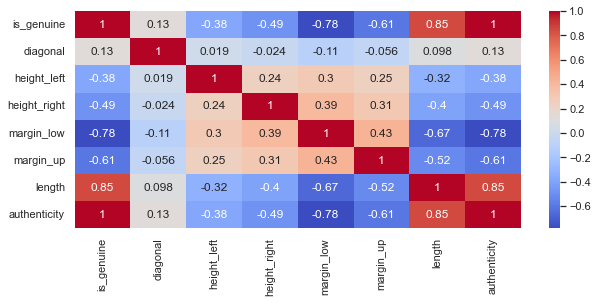

In [12]:
sns.set(rc={'figure.figsize':(10,4)})
billets_corr = billets.corr()
sns.heatmap(billets_corr, xticklabels = billets_corr.columns , 
                 yticklabels = billets_corr.columns, cmap = 'coolwarm', annot=True)

Lançons une régression linéaire multiple sur nos données :

In [13]:
reg_multi = smf.ols('margin_low ~ diagonal+height_left+height_right+margin_up+length+authenticity', data=billets.dropna()).fit()

Voici les résultats en sortie de cette commande :

In [14]:
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          4.75e-299
Time:                        21:37:07   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

Le $R^{2}$ et le $R^{2}$ ajusté valent environ 0.62.

#### Retrait des variables non significatives

On va donc maintenant retirer les variables non significatives. On commence par la moins significative : *length*, car elle a une p-valeur de 0.87.

In [15]:
reg_multi = smf.ols('margin_low ~ diagonal+height_left+height_right+margin_up+authenticity', data=billets.dropna()).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          2.12e-300
Time:                        21:37:07   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.4247      7.873      0.308   

On voit alors que c'est maintenant *diagonal*, avec une p-valeur de 0.72, qui est la moins significative. Nous l'enlevons donc.

In [16]:
reg_multi = smf.ols('margin_low ~ height_left+height_right+margin_up+authenticity', data=billets.dropna()).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          8.76e-302
Time:                        21:37:07   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3902      5.476      0.071   

Avec une p-valeur de près de 0.5, c'est au tour de *height_right* d'être supprimée.

In [17]:
reg_multi = smf.ols('margin_low ~ height_left+margin_up+authenticity', data=billets.dropna()).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          3.63e-303
Time:                        21:37:07   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.9104      4.035      0.721   

Nous allons maintenant supprimer *height_left* qui, avec une p-valeur de 0.45, a la p-valeurs la moins significative. Nous l'enlevons donc aussi.

In [18]:
reg_multi = smf.ols('margin_low ~ margin_up+authenticity', data=billets.dropna()).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          1.24e-304
Time:                        21:37:07   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.9263      0.198     30.003   

Nous avons enfin un modèle de régression linéaire multiple stable nous permettant de remplacer les valeurs manquantes.

Nous aurions également pu obtenir ce résultat en automatisant la procédure comme ceci :

In [19]:
columns = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length', 'authenticity']
reg_backward = backward_selected(billets[columns].dropna(), 'margin_low')

_______________________________
margin_low ~ height_right + diagonal + height_left + margin_up + length + authenticity + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ height_right + diagonal + height_left + margin_up + authenticity + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_right + height_left + margin_up + authenticity + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ height_left + margin_up + authenticity + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + authenticity + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:      

Jetons un oeil (éventuellement) sur les droites de régression de '*margin_low*' en fonction de '*margin_up*' et de '*is_genuine*'.

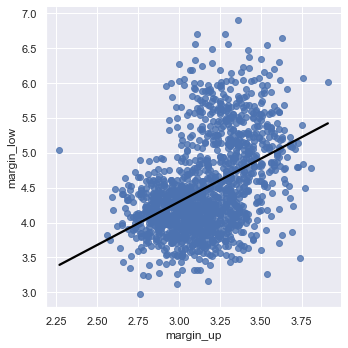

In [20]:
# Affichage de la droite de régression de 'margin_low' en fonction de 'margin_up'

sns.set()
ax = sns.lmplot(x='margin_up', y='margin_low', data=billets.dropna(), ci=None, line_kws={'color':'black'})
ax.set(xlabel='margin_up', ylabel='margin_low')
plt.show()

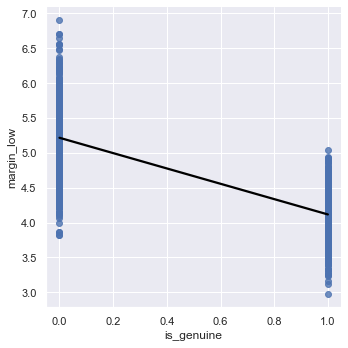

In [21]:
# Affichage de la droite de régression de 'margin_low' en fonction de 'is_genuine'

sns.set()
ax = sns.lmplot(x='is_genuine', y='margin_low', data=billets.dropna(), ci=None, line_kws={'color':'black'})
ax.set(xlabel='is_genuine', ylabel='margin_low')
plt.show()

In [22]:
# Création d'un premier dataframe ne contenant que les billets dont les données sont complètes

billets_df = billets.dropna()
billets_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1


In [23]:
# Création d'un second dataframe ne contenant que les billets dont les données sont incomplètes

billets_na = billets[billets['margin_low'].isnull()]
billets_na.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity
72,True,171.94,103.89,103.45,NaN,3.25,112.79,1
99,True,171.93,104.07,104.18,NaN,3.14,113.08,1
151,True,172.07,103.80,104.38,NaN,3.02,112.93,1
197,True,171.45,103.66,103.80,NaN,3.62,113.27,1
241,True,171.83,104.14,104.06,NaN,3.02,112.36,1


#### Application de la régression linéaire

Nous allons maintenant appliquer le modèle de régression que nous avons obtenu à *billets_na* afin de remplacer les valeurs manquantes.

In [24]:
# Création de la variable 'margin_low_prev', prédiction obtenue à partir du modèle que nous avons précédemment obtenu

billets_na['margin_low_prev'] = round(reg_multi.predict(billets_na), 2)
billets_na.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity,margin_low_prev
72,True,171.94,103.89,103.45,NaN,3.25,112.79,1,4.07
99,True,171.93,104.07,104.18,NaN,3.14,113.08,1,4.10
151,True,172.07,103.80,104.38,NaN,3.02,112.93,1,4.12
197,True,171.45,103.66,103.80,NaN,3.62,113.27,1,4.00
241,True,171.83,104.14,104.06,NaN,3.02,112.36,1,4.12


In [25]:
# Remplacement des valeurs manquantes

billets_na['margin_low'] = billets_na['margin_low_prev']
del billets_na['margin_low_prev']
billets_na.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity
72,True,171.94,103.89,103.45,4.07,3.25,112.79,1
99,True,171.93,104.07,104.18,4.10,3.14,113.08,1
151,True,172.07,103.80,104.38,4.12,3.02,112.93,1
197,True,171.45,103.66,103.80,4.00,3.62,113.27,1
241,True,171.83,104.14,104.06,4.12,3.02,112.36,1


In [26]:
# Réunion de 'billets_df' et 'billets_na'

billets2 = pd.concat([billets_df, billets_na])
billets2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1


Vérifions si nos données sont bien complètes cette fois :

In [27]:
billets2.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
authenticity    0
dtype: int64

In [28]:
billets2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
 7   authenticity  1500 non-null   int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 95.2 KB


In [29]:
billets2.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000
mean,171.958440,104.029533,103.920307,4.482873,3.151473,112.67850,0.666667
std,0.305195,0.299462,0.325627,0.659856,0.231813,0.87273,0.471562
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000,0.000000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000,0.000000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000,1.000000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000,1.000000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000,1.000000


Tout est ok.

### Représentation et analyse des résidus
 
Intéressons-nous maintenant aux résidus.

In [30]:
billets2['residu_s'] = reg_multi.resid

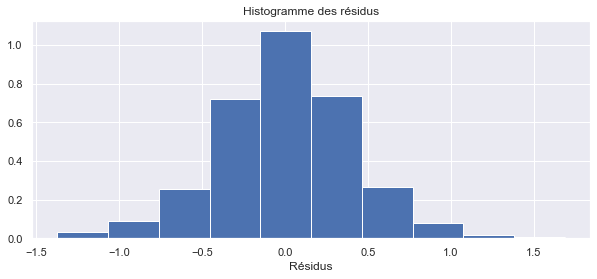

In [31]:
plt.hist(billets2['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

La distribution des résidus semble suivre une loi normale (le modèle propose une distribution gaussienne, homogène, centrée et symétrique), mais vérifions si c'est réellement le cas en efectuant un test de Shapiro-Wilk.

**H0 :** les résidus ont une distribution normale

**H1 :** les résidus ne suivent pas la loi normale

In [32]:
# Test de Shapiro-Wilk

shapiro(reg_backward.resid)

ShapiroResult(statistic=0.9936250448226929, pvalue=6.211516392795602e-06)

La p-value étant inférieure à 5%, nous pouvons rejeter H0 et donc admettre que, malgré l'allure de l'histogramme, la distibution des résidus ne suit finalement pas la loi normale.

Intéressons-nous également à l'homoscédasticité en réalisant un test de Breusch-Pagan.

**H0 :** l'homoscédasticité est présente

**H1 :** l'homoscédasticité n'est pas présente (il y a donc hétéroscédasticité)

In [33]:
# Test de Breusch-Pagan

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(reg_backward.resid , reg_backward.model.exog)
lzip(names, test)

[('Lagrange multiplier statistic', 163.45772873027093),
 ('p-value', 3.2033559115828504e-36),
 ('f-value', 91.82013129631493),
 ('f p-value', 2.745628359363466e-38)]

La p-value étant nettement inférieure à 5%, nous pouvons rejeter H0 et admettre la présence d'une hétéroscédasticité. Cependant, celle-ci n'aura pas d'influence sur la valeur des coefficients, et donc sur la valeur de la prédiction.

### Détection de problème de (multi-)colinéarité

Nous allons maintenant vérifier si (multi-)colinéarité il y a entre nos variables explicatives en utilisant le facteur d'influence de la variance (VIF).

In [34]:
# Calcul du facteur d'influence de la variance (VIF)

y, X = dmatrices('authenticity ~ length + height_left + diagonal + margin_up + margin_low + height_right', data=billets2, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Variables'] = X.columns
vif

,VIF,Variables
0,593847.997180,Intercept
1,2.137842,length
2,1.158944,height_left
3,1.017872,diagonal
4,1.417581,margin_up
5,1.920006,margin_low
6,1.259225,height_right


Tous les VIF obtenus sont compris entre 1 et 5, et qui plus est relativement proches de 1. Le modèle sera donc (semble-t-il) plutôt robuste, la corrélation entre les différentes variables explicatives étant suffisamment modérée pour être ignorée.

### Analyse descriptive des données

Nous allons maintenant jeter un oeil sur nos données complètes.

<Figure size 864x576 with 0 Axes>

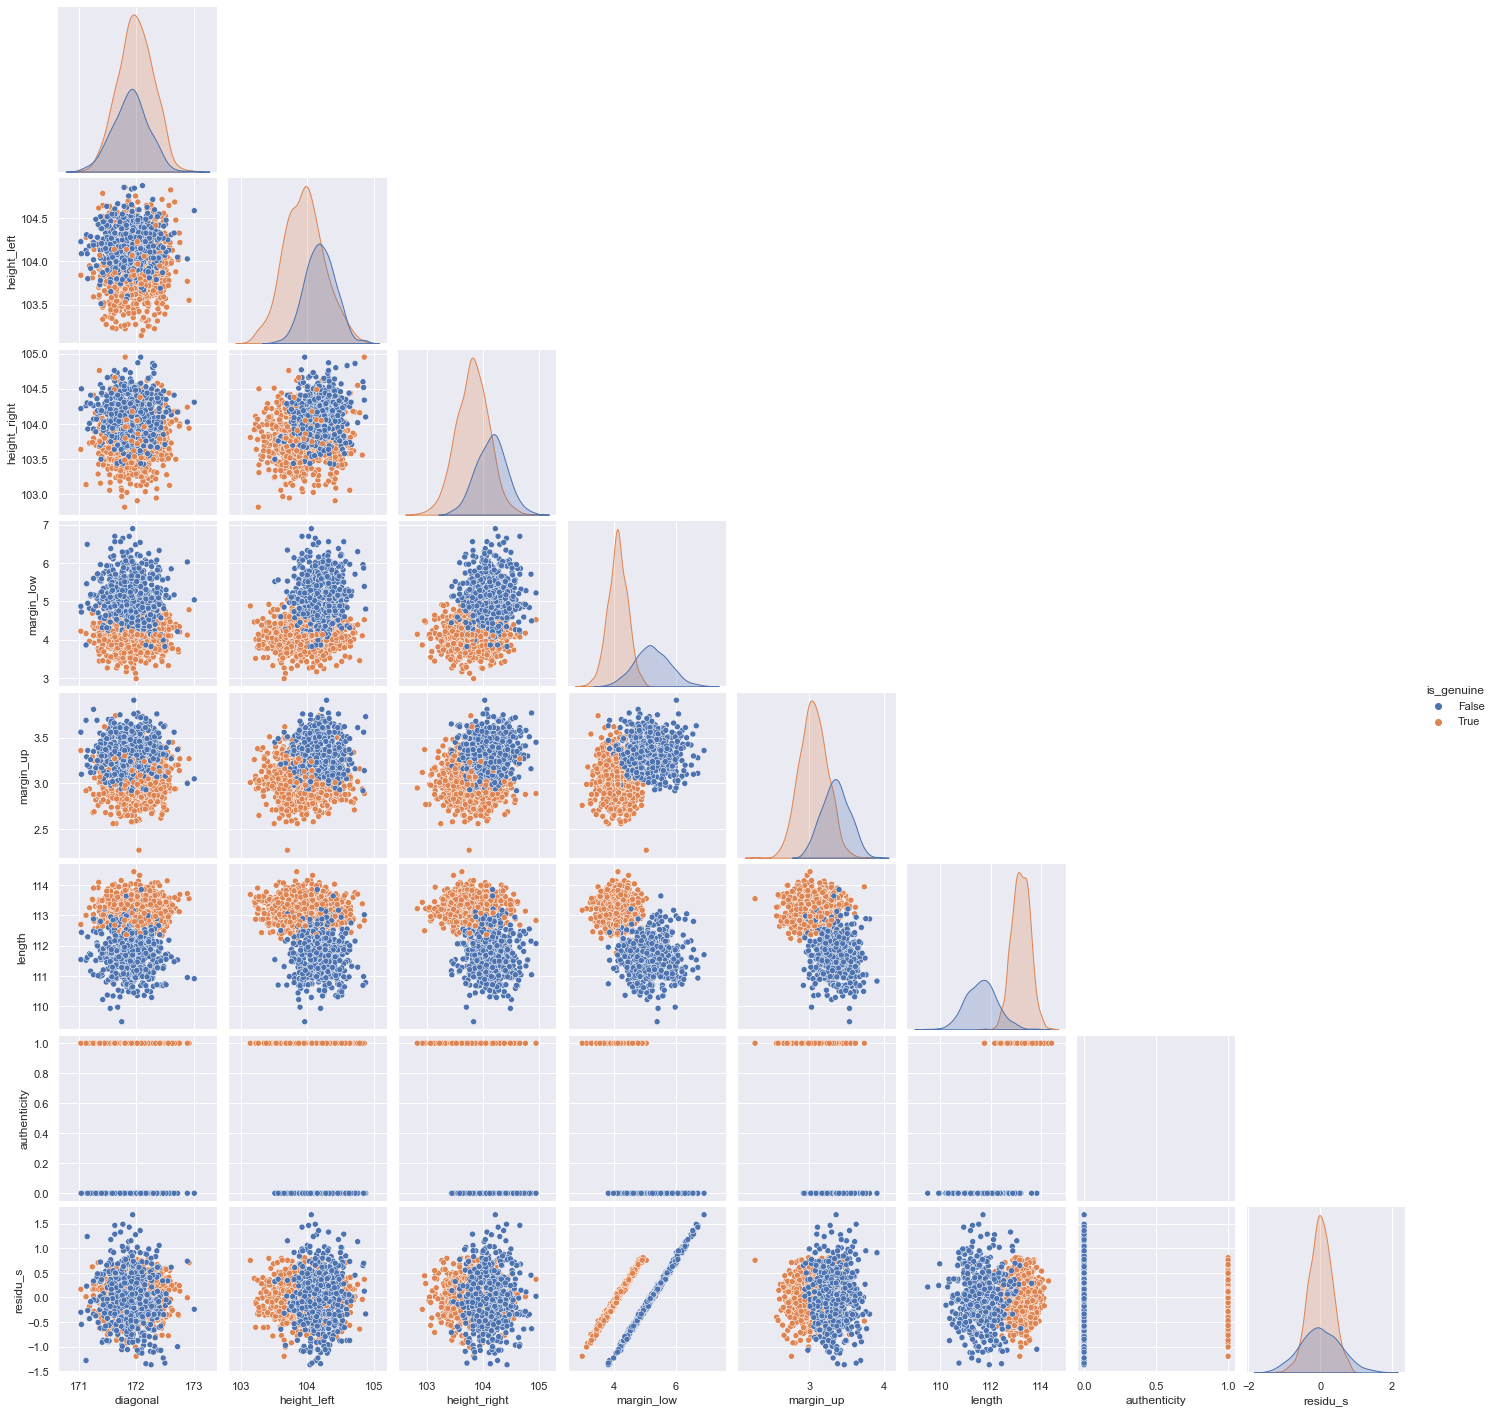

In [35]:
# Affichage de la répartition des individus en fonction de leur authenticité

plt.figure(figsize=(12, 8))
sns.pairplot(billets2, hue='is_genuine', corner=True)

En ne nous basant que sur ces pairplots, nous pouvons observer qu'en ce qui concerne la variable '*length*', les deux groupes (vrais et faux billets) semblent se démarquer plus que pour les autres variables.

Intéressons également à la réparation globale des observation, puis à leur répartition en fonction de leur authenticité.

<AxesSubplot:ylabel='length'>

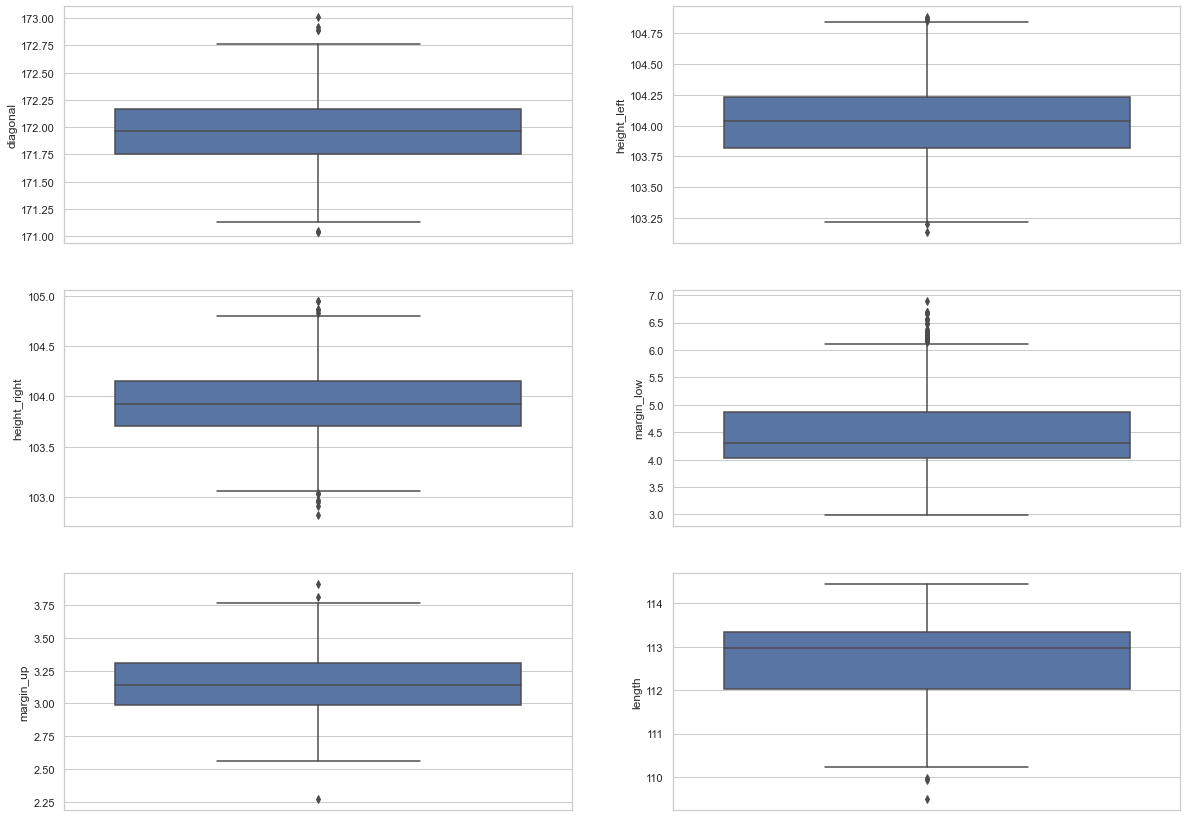

In [36]:
# Boxplots de la répartition globale des billets

plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(421)
sns.boxplot(data=billets2,y='diagonal')

plt.subplot(422)
sns.boxplot(data=billets2, y='height_left')

plt.subplot(423)
sns.boxplot(data=billets2, y='height_right')

plt.subplot(424)
sns.boxplot(data=billets2,y='margin_low')

plt.subplot(425)
sns.boxplot(data=billets2, y='margin_up')

plt.subplot(426)
sns.boxplot(data=billets2,y='length')

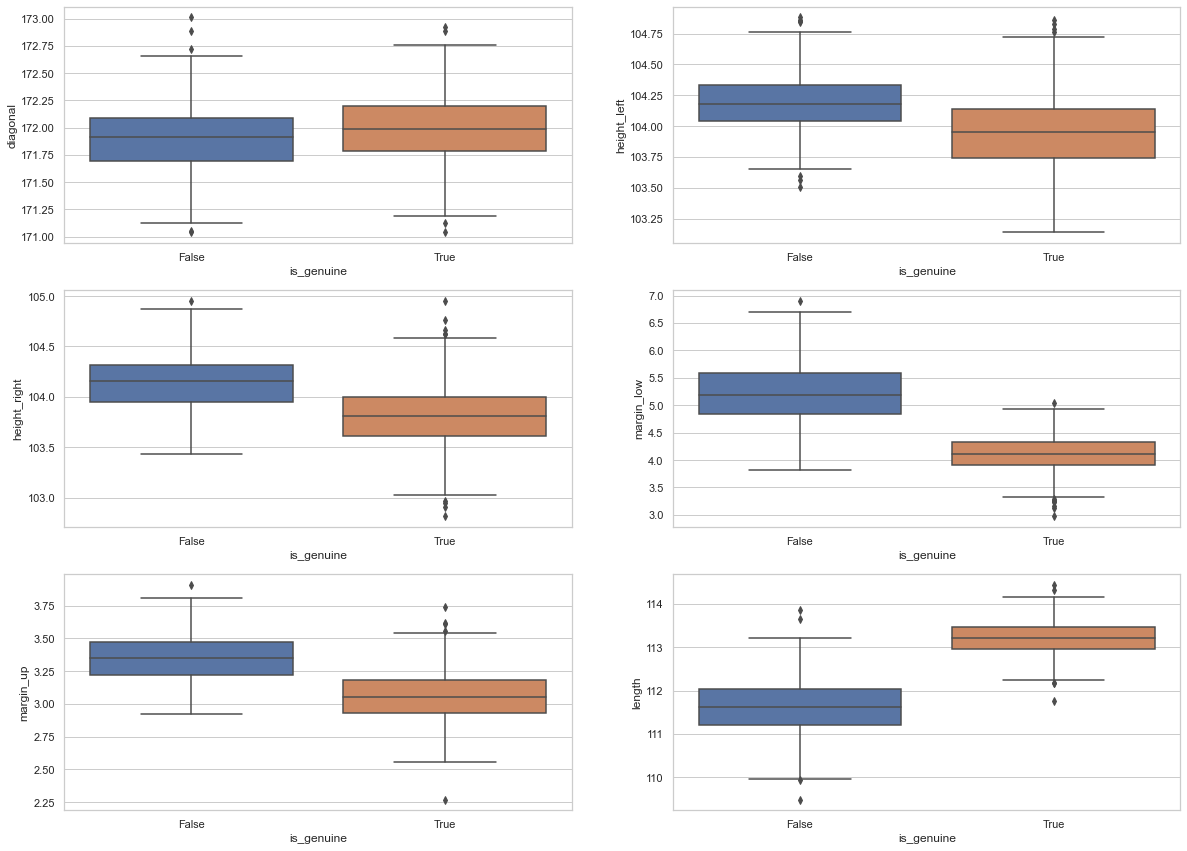

In [37]:
# Boxplots de la répartition des billets en fonction de leur authenticité

plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(421)
sns.boxplot(x='is_genuine', y='diagonal', data=billets2)

plt.subplot(422)
sns.boxplot(x='is_genuine', y='height_left', data=billets2)

plt.subplot(423)
sns.boxplot(x='is_genuine', y='height_right', data=billets2)

plt.subplot(424)
sns.boxplot(x='is_genuine', y='margin_low', data=billets2)

plt.subplot(425)
sns.boxplot(x='is_genuine', y='margin_up', data=billets2)

plt.subplot(426)
sns.boxplot(x='is_genuine', y='length', data=billets2)

plt.show(block=False)

Il semblerait que l'authenticité d'un billet soit fortement liée à la variable "*length*". Réalisons des tests statistiques afin de voir quelles variables influencent l'authenticité des billets. Utilisons pour ce faire l'analyse des variances ou ANOVA.

**H0 :** les moyennes des variances de tous les groupes sont égales.

**H1 :** les moyennes des variances des groupes sont différentes.

In [38]:
f_oneway(billets2[billets2.is_genuine == True]['diagonal'], billets2[billets2.is_genuine == False]['diagonal'])

F_onewayResult(statistic=26.874763461800534, pvalue=2.4668667372399823e-07)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que l'authencité des billets est corrélée à la variable  "*diagonal*".

In [39]:
f_oneway(billets2[billets2.is_genuine == True]['height_left'], billets2[billets2.is_genuine == False]['height_left'])

F_onewayResult(statistic=252.55839309812222, pvalue=1.1269164017506187e-52)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que l'authencité des billets est corrélée à la variable  "*height_left*".

In [40]:
f_oneway(billets2[billets2.is_genuine == True]['height_right'], billets2[billets2.is_genuine == False]['height_right'])

F_onewayResult(statistic=460.97421232930486, pvalue=2.2708556903089336e-89)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que l'authencité des billets est corrélée à la variable  "*height_right*".

In [41]:
f_oneway(billets2[billets2.is_genuine == True]['margin_low'], billets2[billets2.is_genuine == False]['margin_low'])

F_onewayResult(statistic=2423.6929554082076, pvalue=2.317723683e-315)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que l'authencité des billets est corrélée à la variable  "*margin_low*".

In [42]:
f_oneway(billets2[billets2.is_genuine == True]['margin_up'], billets2[billets2.is_genuine == False]['margin_up'])

F_onewayResult(statistic=870.581394261039, pvalue=3.1445303087223535e-151)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que l'authencité des billets est corrélée à la variable  "*margin_up*".

In [43]:
f_oneway(billets2[billets2.is_genuine == True]['length'], billets2[billets2.is_genuine == False]['length'])

F_onewayResult(statistic=3876.6541378261672, pvalue=0.0)

La pvalue étant nulle (et donc inférieure à 0.05), nous pouvons rejeter H0 et admettre, par conséquent, que l'authencité des billets est corrélée à la variable  "*length*".

In [44]:
# Coup d'oeil sur la description des données 

billets2.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity,residu_s
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1.463000e+03
mean,171.958440,104.029533,103.920307,4.482873,3.151473,112.67850,0.666667,1.502557e-15
std,0.305195,0.299462,0.325627,0.659856,0.231813,0.87273,0.471562,4.110464e-01
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000,0.000000,-1.370821e+00
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000,0.000000,-2.638627e-01
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000,1.000000,-6.695606e-03
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000,1.000000,2.594536e-01
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000,1.000000,1.685866e+00


### Calcul des proportions de billets

Afin de faciliter notre travail futur, calculons les classes de longueur et les proportions de vrais et faux billets qui leurs sont associées.

In [45]:
# Découpage des classes

billets2['length_cl'] = pd.cut(billets2['length'], bins = np.arange(109.49, 114.99, 0.5), right=True)
billets2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,authenticity,residu_s,length_cl
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1,0.369454,"(112.49, 112.99]"
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1,-0.359352,"(112.99, 113.49]"
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1,0.260051,"(112.99, 113.49]"
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1,-0.505114,"(113.49, 113.99]"
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1,0.014498,"(112.49, 112.99]"


In [46]:
# Affichage de toutes les classes créées

print(billets2['length_cl'].unique())

[(112.49, 112.99], (112.99, 113.49], (113.49, 113.99], (111.99, 112.49], (113.99, 114.49], ..., (110.99, 111.49], (110.49, 110.99], (109.99, 110.49], NaN, (109.49, 109.99]]
Length: 11
Categories (10, interval[float64, right]): [(109.49, 109.99] < (109.99, 110.49] < (110.49, 110.99] < (110.99, 111.49] ... (112.49, 112.99] < (112.99, 113.49] < (113.49, 113.99] < (113.99, 114.49]]


In [47]:
# Calcul des proportions associées aux classes

prop = pd.crosstab(billets2['length_cl'], billets2['is_genuine'], normalize='index')
prop

is_genuine,False,True
length_cl,,
"(109.49, 109.99]",1.000000,0.000000
"(109.99, 110.49]",1.000000,0.000000
"(110.49, 110.99]",1.000000,0.000000
"(110.99, 111.49]",1.000000,0.000000
"(111.49, 111.99]",0.993827,0.006173
"(111.99, 112.49]",0.767442,0.232558
"(112.49, 112.99]",0.106007,0.893993
"(112.99, 113.49]",0.009940,0.990060
"(113.49, 113.99]",0.009662,0.990338


In [48]:
prop_genuine = pd.DataFrame(data = {'length': np.concatenate((np.array([109.49]),
                                                       np.repeat(np.arange(109.99, 114.49, 0.5), repeats=2),
                                                       np.array([114.49])), axis=0),
                                'prop_genuine': np.repeat(prop.loc[:,1].values, repeats=2)})
prop_genuine

,length,prop_genuine
0,109.49,0.000000
1,109.99,0.000000
2,109.99,0.000000
3,110.49,0.000000
4,110.49,0.000000
5,110.99,0.000000
6,110.99,0.000000
7,111.49,0.000000
8,111.49,0.006173
9,111.99,0.006173


Représentons ces proportions :

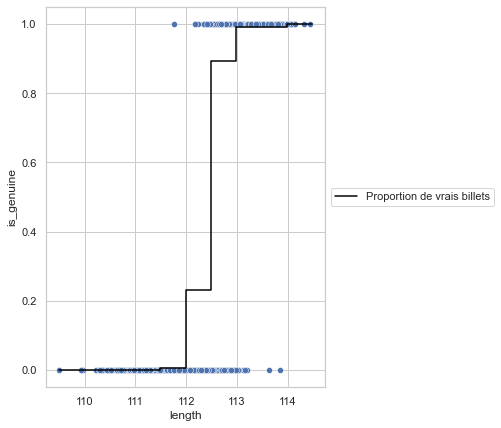

In [49]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x="length", y="is_genuine", data=billets2)
plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion de vrais billets')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Nous obtenons une fonction en escalier qui tend à démontrer que la variable "*length*" peut être un élément intéressant permettant de différencier les billets.

### Séparation des données

Nous allons maintenant séparer nos données afin d'avoir une partie sur laquelle nous entraînerons notre modèle et une seconde sur laquelle nous testerons le modèle obtenu.

In [50]:
# Séparation des données sur une base de 80% - 20%

X = billets2.drop(['is_genuine','authenticity', 'length_cl', 'residu_s'], axis=1)
y = billets2['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=242)

In [51]:
print(X_train.shape)
print(X_test.shape)

(1200, 6)
(300, 6)


In [52]:
print(y_train.shape)
print(y_test.shape)

(1200,)
(300,)


### Utilisation de l'algorithme des KMeans sur les données d'entrainement

In [53]:
# Convertion des données en array numpy
# Centrage et réduction des valeurs

X = X_train.values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

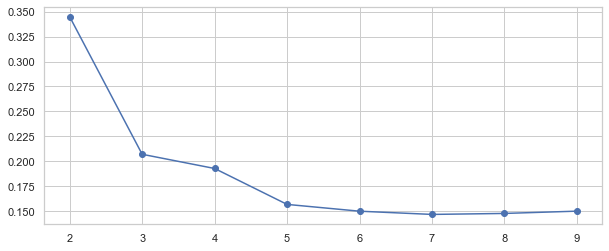

In [54]:
# Établissement du nombre de clusters optimal à l'aide de la métrique "silhouettes" 

silhouettes = [] 
for num_clusters in range(2, 10): 
    cls = KMeans(n_clusters=num_clusters, random_state=1512)  
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

Nous allons choisir de grouper notre échantillon en 2 clusters. Créons une liste dans laquelle nous stockerons les différentes inerties

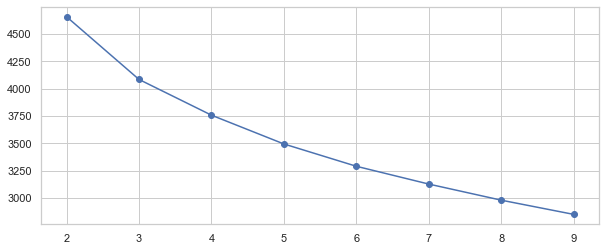

In [55]:
# Création de la liste des inerties

inerties=[]
for k in range(2, 10):
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    inerties.append(km.inertia_)

plt.plot(range(2, 10), inerties, marker='o')
plt.show()

La courbe des inerties nous indique que nous devrions effectivement choisir k=2.

Nous pouvons maintenant réaliser une analyse en composantes principales (ACP) afin de poursuivre notre étude.

In [56]:
# Réalisation d'une ACP sur notre échantillon

pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [57]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.43082565 0.16939327]
[0.43082565 0.60021892]


In [58]:
# Classifictaion K-Means en 2 clusters

cls2 = KMeans(n_clusters=2)
cls2.fit(X_scaled)

KMeans(n_clusters=2)

In [59]:
# Vérification par le biais d'une PCA

pca = PCA(svd_solver='full')
pca.fit(X_scaled)
X_trans = pca.transform(X_scaled)
print(pca.explained_variance_ratio_.cumsum())

[0.43082565 0.60021892 0.73119423 0.84767181 0.94668407 1.        ]


Environ 60% de la variance des données est expliquée par ses 2 premières composantes. Réalisons un diagramme des éboulis des valeurs propres pour confirmer.

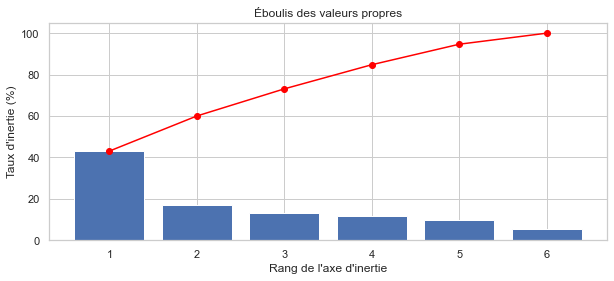

In [60]:
# Confirmation graphique du nombre de clusters à choisir

pevr = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(pevr))+1, pevr)
plt.plot(np.arange(len(pevr))+1, pevr.cumsum(),c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Taux d'inertie (%)")
plt.title("Éboulis des valeurs propres")
plt.show()

Nous pouvons effectivement constater une forte représentation de nos variables sur le premier plan factoriel.

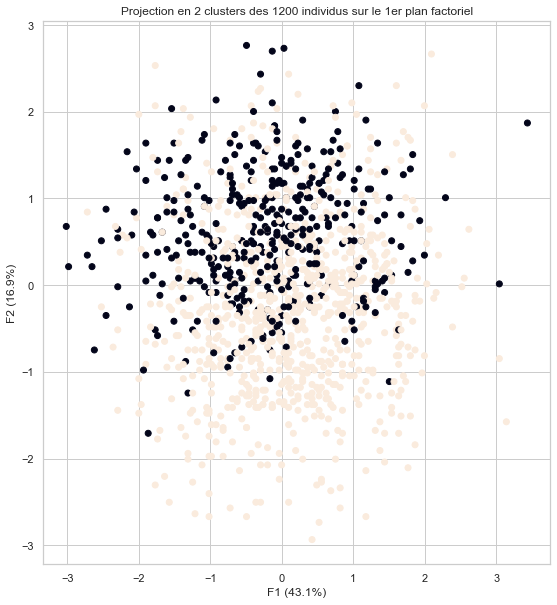

In [61]:
# Projection des données sur le premier plan factoriel

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cls2.labels_)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_trans.shape[0]))

plt.show()

In [62]:
# Tableau des centroïdes dans sa version centrée et réduite (facilitant la comparaison, les dimensions prenant toutes la même importance)

centroids = cls2.cluster_centers_
pd.DataFrame(centroids, columns=X_train.columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.222137,0.586306,0.737462,1.130206,0.869112,-1.232050
1,0.104936,-0.276967,-0.348371,-0.533901,-0.410562,0.582011


In [63]:
# Tri des index des clusters et affichage des observations en fonction de leurs classes

index = np.argsort(cls2.labels_)
data_cls2 = pd.DataFrame(X_train.index[index], cls2.labels_[index]).reset_index()
data_cls2 = data_cls2.rename(columns={'index':'Cluster'})
data_cls2 = data_cls2.set_index(0)

Maintenant que nous avons nos 2 clusters, joignons les à notre dataframe global.

In [64]:
# Jointure avec notre dataframe de départ

data_cls2 = pd.merge(X_train, data_cls2, left_index=True, right_index=True)
data_cls2.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,Cluster
1159,171.47,104.33,104.03,5.25,3.01,111.68,0
378,172.06,104.24,103.66,4.24,3.10,113.02,1
1484,172.08,103.96,104.95,5.22,3.45,112.07,0
781,171.93,104.34,103.72,3.78,2.93,113.52,1
1453,171.55,104.20,104.49,5.42,3.54,109.93,0


In [65]:
print(data_cls2[data_cls2['Cluster'] == 0].shape)
print(data_cls2[data_cls2['Cluster'] == 1].shape)

(385, 7)
(815, 7)


In [66]:
data_cls2.groupby('Cluster').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
Cluster,,,,,,
0,171.892416,104.202494,104.155351,5.205844,3.344831,111.630831
1,171.992307,103.942037,103.802454,4.120589,3.049877,113.204577


Nous allons maintenant réaliser un heatmap afin de représenter visuellement les caractéristiques des différents clusters.

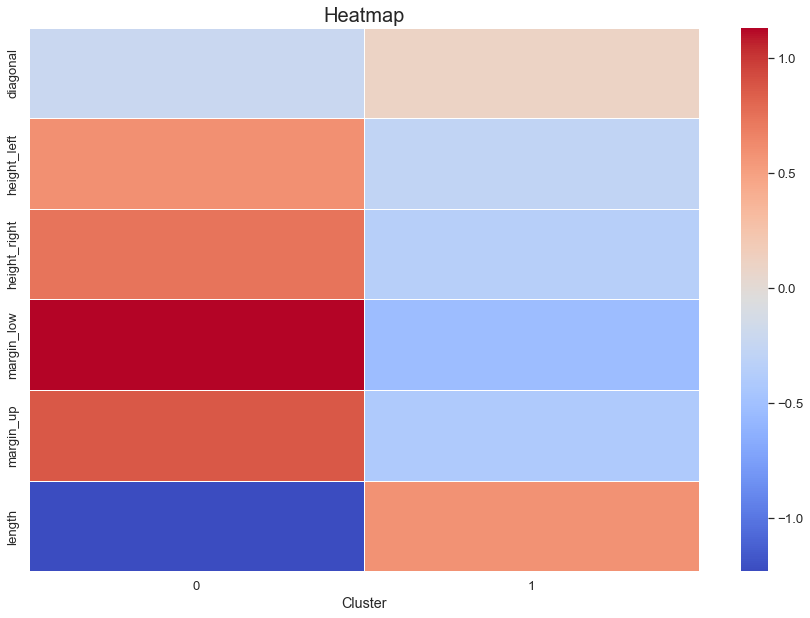

In [67]:
# Heatmap

X_scaled_df = pd.DataFrame(X_scaled, index=data_cls2.index, columns = data_cls2[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length', 'Cluster']].drop(columns = ['Cluster']).columns)
X_scaled_df['Cluster'] = cls2.labels_
heatmap_df = X_scaled_df.groupby("Cluster").mean().transpose()
sns.set(font_scale = 1.2)
f, ax = plt.subplots(figsize = (15, 10))
ax.set_title('Heatmap', fontsize = 20)
ax = sns.heatmap(heatmap_df, linewidths = .5, cmap = "coolwarm")

Le cluster 1 est composé des billets ayant les valeurs les plus élevées pour les variables *diagonal* et *length*. Le cluster 0 est composé des billets ayant les valeurs les plus élevées pour les autres variables.

#### Projection des variables sur le premier plan factoriel

Nous allons, pour simplifier la compréhension de nos résultats, essayer de synthétiser nos variables en les groupant, et ainsi obtenir 2 variables uniques (F1 et F2) qui seront nos composantes principales.

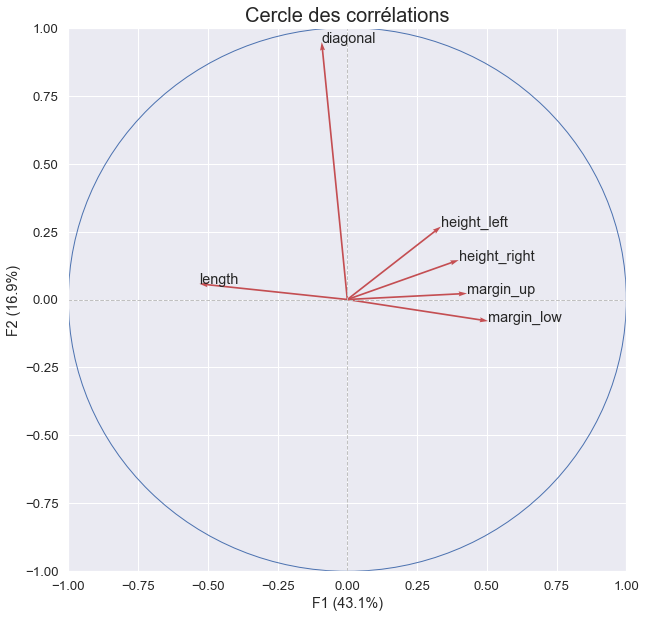

In [68]:
# Réalisation d'un cercle des corrélations

pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], 
           angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, X_train.columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations', fontsize=20)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.show()

Les variables "*margin (up et low)*" et "*height (left et right)*" sont fortement corrélées entre elles (à confirmer en regardant les cosinus carrés).

Les variables "*margin (up et low)*" et "*length*" semblent ëtre corrélées à la composante principale F1 (à confirmer en regardant les cosinus carrés).

La variable "*diagonal*" semble quant à elle être fortement corrélée à la composante principale F2 (à confirmer en regardant les cosinus carrés).

In [69]:
# Calcul des composantes principales
# Ici seulement F1 et F2 seront utiles à l'interprétation attendue

data_cp = pd.DataFrame(X_trans, index=data_cls2.index, columns=["F" + str(i+1) for i in range(6)])
data_cp.head()

,F1,F2,F3,F4,F5,F6
1159,1.603537,-1.374104,1.073975,0.679890,-0.861308,-0.241928
378,-0.561190,0.430594,0.902794,-0.459402,-0.016507,0.022519
1484,2.695877,0.671091,-1.693375,1.525647,0.903399,0.458820
781,-1.315074,0.215904,1.534780,0.277447,0.338501,-0.103965
1453,4.187459,-1.121968,-0.597846,0.085278,0.109621,-1.164245


In [70]:
# Coefficients des composantes principales F1 et F2

F1 = pca.components_[0]
F2 = pca.components_[1]
print(F1)
print(F2)

[-0.09180514  0.3354868   0.39914023  0.50446979  0.42895515 -0.53029728]
[ 0.94702445  0.26832116  0.14509148 -0.07927459  0.02225381  0.05759523]


#### Répartition des clusters

<AxesSubplot:xlabel='Cluster', ylabel='length'>

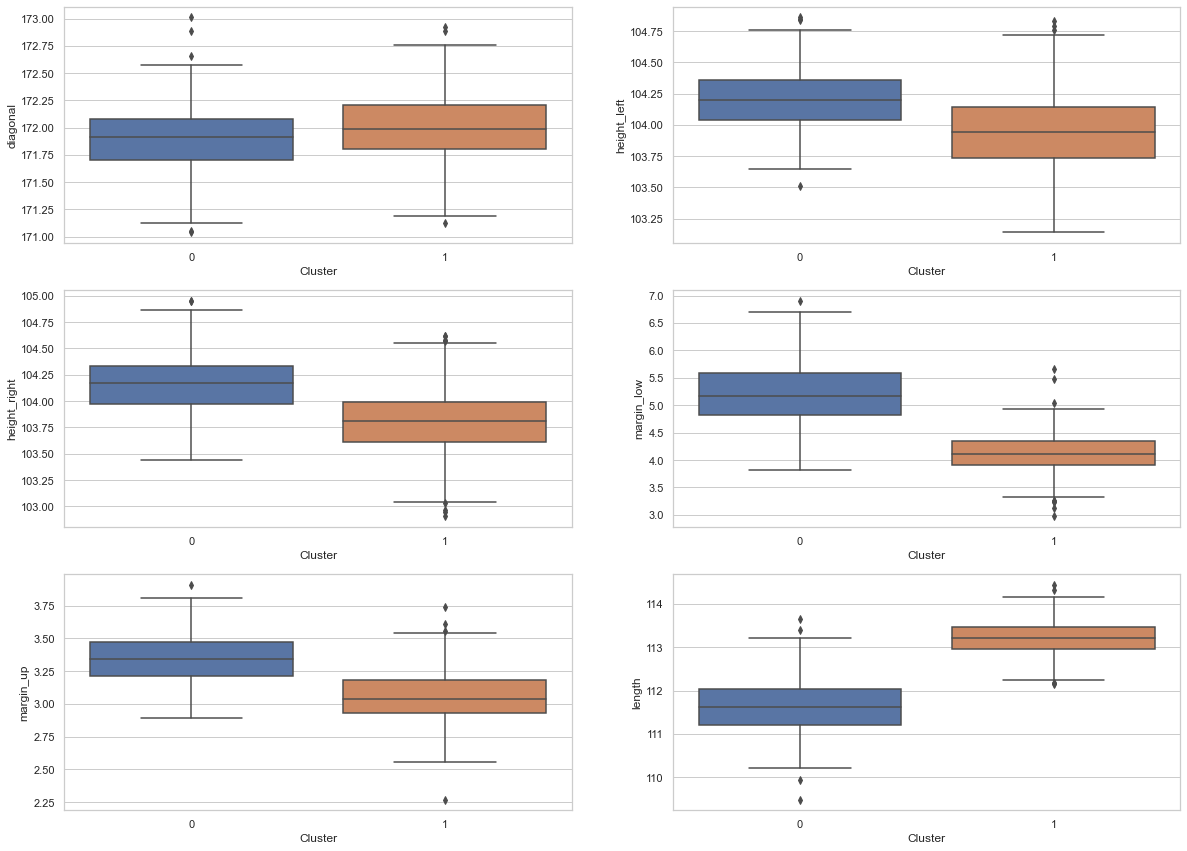

In [71]:
# Réalisation de boxplots afin de visualiser la répartition des classes

plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(421)
sns.boxplot(data=data_cls2, x='Cluster', y='diagonal')

plt.subplot(422)
sns.boxplot(data=data_cls2, x='Cluster', y='height_left')

plt.subplot(423)
sns.boxplot(data=data_cls2, x='Cluster', y='height_right')

plt.subplot(424)
sns.boxplot(data=data_cls2, x='Cluster', y='margin_low')

plt.subplot(425)
sns.boxplot(data=data_cls2, x='Cluster', y='margin_up')

plt.subplot(426)
sns.boxplot(data=data_cls2, x='Cluster', y='length')

Réalisons des tests statistiques afin de voir quelles variables influencent la composition des clusters. Utilisons pour ce faire l'analyse des variances ou ANOVA.

**H0 :** les moyennes des variances de tous les groupes sont égales.

**H1 :** les moyennes des variance des groupes sont différentes.

In [72]:
f_oneway(data_cls2[data_cls2.Cluster == 0]['diagonal'], data_cls2[data_cls2.Cluster == 1]['diagonal'])

F_onewayResult(statistic=28.592069293850717, pvalue=1.0692137410319138e-07)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que la composition des clusters est corrélée à la variable  "*diagonal*".

In [73]:
f_oneway(data_cls2[data_cls2.Cluster == 0]['height_left'], data_cls2[data_cls2.Cluster == 1]['height_left'])

F_onewayResult(statistic=232.25527537384966, pvalue=4.554182467858226e-48)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que la composition des clusters est corrélée à la variable  "*height_left*".

In [74]:
f_oneway(data_cls2[data_cls2.Cluster == 0]['height_right'], data_cls2[data_cls2.Cluster == 1]['height_right'])

F_onewayResult(statistic=414.1882026727491, pvalue=2.5721477058928606e-79)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que la composition des clusters est corrélée à la variable  "*height_right*".

In [75]:
f_oneway(data_cls2[data_cls2.Cluster == 0]['margin_low'], data_cls2[data_cls2.Cluster == 1]['margin_low'])

F_onewayResult(statistic=1822.8173091201356, pvalue=7.467168617569253e-243)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que la composition des clusters est corrélée à la variable  "*margin_low*".

In [76]:
f_oneway(data_cls2[data_cls2.Cluster == 0]['margin_up'], data_cls2[data_cls2.Cluster == 1]['margin_up'])

F_onewayResult(statistic=664.6334794021077, pvalue=5.957475159918547e-117)

La pvalue étant nettement inférieure à 0.05, nous pouvons rejeter H0 et admettre, par conséquent, que la composition des clusters est corrélée à la variable  "*margin_up*".

In [77]:
f_oneway(data_cls2[data_cls2.Cluster == 0]['length'], data_cls2[data_cls2.Cluster == 1]['length'])

F_onewayResult(statistic=3036.2135092301705, pvalue=0.0)

La pvalue étant nulle, nous pouvons rejeter H0 et admettre, par conséquent, que la composition des clusters est corrélée à la variable  "*length*".

In [78]:
# Affichage des billets ainsi que leurs contributions 

di = np.sum(X_scaled**2,axis=1)
ctr_indiv_inertie = pd.DataFrame(di, index=data_cls2.index, columns=['d_i']).sort_values(by='d_i', ascending=True)
ctr_indiv_inertie

,d_i
290,0.394827
910,0.432524
723,0.442192
1103,0.467211
695,0.515829
...,...
1027,21.143743
1277,21.976755
1029,22.151482
1382,22.720208


### Mise en place de la régression logistique

Créons un modèle de régression logistique que nous entraînerons sur X_train :

In [79]:
# Initialisation du modèle

model=LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Maintenant que nous avons initialisé notre modèle de régression logistique, nous pouvons le tester sur X_train et nous pourrons ensuite vérifier sa fiabilité grâce à y_train :

In [80]:
# Prédiction de l'authenticité des individus de X_train

model.predict(X_train)

array([False,  True, False, ...,  True, False, False])

Affichons les résultats de notre prédiction...

In [81]:
# Matrice de confusion

pd.crosstab(model.predict(X_train), y_train, dropna=False)

is_genuine,False,True
row_0,,
False,379,4
True,7,810


... ainsi que le taux de précision :

In [82]:
# Taux de précision

print(metrics.accuracy_score(y_train, model.predict(X_train)))

0.9908333333333333


La matrice de confusion nous indique que nous avons quelques faux positifs (7) et faux négatifs (4), ce qui nous donne tout de même 1189 individus correctement classés sur 1200.

Avec un taux de précision de 99,08% notre modèle semble donc relativement fiable et peut être appliqué aux données de test (X_test).

In [83]:
# Application du modèle sur X_test

predict = model.predict(X_test)

In [84]:
# Évaluation du modèle

print(metrics.classification_report(y_test, predict))
print(metrics.accuracy_score(y_test, predict))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       114
        True       0.99      1.00      0.99       186

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

0.9933333333333333


In [85]:
pd.crosstab(predict, y_test, dropna=False)

is_genuine,False,True
row_0,,
False,112,0
True,2,186


La matrice de confusion nous indique, cette fois, que nous avons quelques faux positifs (2) et aucun faux négatif, ce qui nous donne 298 individus correctement classés sur 300.

Avec un taux de précision de 99,33% notre modèle semble donc rééllement fiable et poourra être appliqué à d'autres données inconnues.

Testons-le maintenant sur l'échantillon de cinq billets qui a été mis préalablement à notre disposition :

In [86]:
# Chargement de l'échantillon en question

billets_prod = pd.read_csv('Billets_production.csv', sep=",", decimal='.')
billets_prod.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


Essayons, à partir des moyennes des clusters, de déterminer si les billets de notre nouvel échantillon sont vrais ou faux :

In [87]:
# Affichage des moyennes des clusters

data_cls2.groupby('Cluster').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
Cluster,,,,,,
0,171.892416,104.202494,104.155351,5.205844,3.344831,111.630831
1,171.992307,103.942037,103.802454,4.120589,3.049877,113.204577


À partir des moyennes des clusters, nous pourrions admettre que les billets *A_1*, *A_2* et *A_3* appartiennent au cluster 0 et seraient donc faux alors que *A_4* et *A_5* appartiennent au cluster 1 et seraient donc vrais.

Appliquons mainenant notre modèle afin de voir si ces premières impressions sont confirmées ou non.

In [88]:
model.predict(billets_prod.iloc[:,[0, 1, 2, 3, 4, 5]])

array([False, False, False,  True,  True])

In [89]:
model.predict_proba(billets_prod.iloc[:,[0, 1, 2, 3, 4, 5]])

array([[9.94232824e-01, 5.76717551e-03],
       [9.99162136e-01, 8.37864328e-04],
       [9.98600989e-01, 1.39901091e-03],
       [8.51625054e-02, 9.14837495e-01],
       [3.83656665e-04, 9.99616343e-01]])

D'après notre modèle, les probabilités que *A_1*, *A_2* et *A_3* soient faux sont de 99,42%, 99,91% et 99,86%.

Quant à *A_4* et *A_5*, ils ont 91,48% et 99,96% de chance d'être vrais.

### Réalisation d'une régression logistique

Effectuons une régression logistique de *is_genuine* en fonction de *length* :

In [90]:
# Régression logistique en fonction de la longueur
# régression linéaire : y=ax+by+cz+...+u (x,y,z étant les variables explicatives)
# e(ax+by+...)/(e(ax+by+...)+1)

reg_log = smf.glm('is_genuine ~ length', data=billets2, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1498
Model Family:                                       Binomial   Df Model:                            1
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -191.21
Date:                                       Mon, 06 Mar 2023   Deviance:                       382.43
Time:                                               21:37:15   Pearson chi2:                 1.22e+04
No. Iterations:                                            8   Pseudo R-squ. (CS):             0.6387
Covariance Type:                                   nonrobust                      

Nous obtenons les paramètres estimés suivants : $\\hat{\\beta}_{1}=741.9276$ et $\\hat{\\beta}_{2}=-6.5967$ 

Enregistrons-les :

In [91]:
beta1 = reg_log.params[0]
beta2 = reg_log.params[1]

Dans le but de tracer la courbe logistique entre les abscisses $x=109.49$ et $x=114.49$, définissons une séquence de 109.49 à 114.49 par pas de 500, puis plaçons la dans la variable x. Nous calculerons ensuite les ordonnées de la courbe, grâce à l'expression de la courbe en S :

$f(x) = frac{e^{\\beta_{1}+\\beta_{2}x}}{1+e^{\\beta_{1}+\\beta_{2}x}}$</font></center>

Nous plaçons ces ordonnées dans la variable y. Enfin, avec x et y, nous créons un dataframe :

In [92]:
x = np.linspace(start=109.49, stop=114.99, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log = pd.DataFrame(data={'length': x, 'prop_genuine': y})

Nous pouvons maintenant superposer la fonction de lien obtenue par régression logistique sur le graphique précédent, nous obtenons ceci :

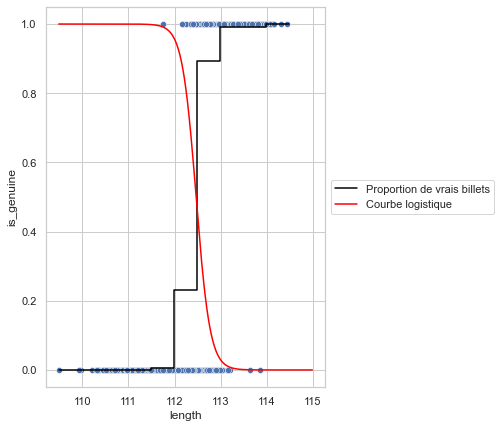

In [93]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x="length", y="is_genuine", data=billets2)
plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion de vrais billets')
plt.plot(reg_log['length'], reg_log['prop_genuine'], color='red', label='Courbe logistique')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Application de l'algorithme

Nous allons maintenant appliquer l'algorithme aux données qui nous ont été fournies en direct :

In [94]:
# Chargement des données

test_direct = pd.read_csv('billets_test.csv', sep=",", decimal='.')
test_direct

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [95]:
# Affichage des moyennes des clusters

data_cls2.groupby('Cluster').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
Cluster,,,,,,
0,171.892416,104.202494,104.155351,5.205844,3.344831,111.630831
1,171.992307,103.942037,103.802454,4.120589,3.049877,113.204577


In [96]:
model.predict(test_direct.iloc[:,[0, 1, 2, 3, 4, 5]])

array([ True, False,  True, False, False])

In [97]:
model.predict_proba(test_direct.iloc[:,[0, 1, 2, 3, 4, 5]])

array([[1.06928926e-02, 9.89307107e-01],
       [9.91447932e-01, 8.55206847e-03],
       [8.92782178e-04, 9.99107218e-01],
       [9.99827221e-01, 1.72778581e-04],
       [9.86665772e-01, 1.33342282e-02]])